In [764]:
import pandas as pd
import re
import time

In [836]:
def assign_year(row):
    match = re.search(r'\((19[0-9][0-9]|20[0-9][0-9])\)', row['title'])
    if match:
        return match[0][1:-1]  
    else:
        match1 = re.search(r'\((19[0-9][0-9]|20[0-9][0-9])–(19[0-9][0-9]|20[0-9][0-9])\)', row['title'])
        if match1:
            return match1[0][1:5] #возвращаю первый год выпуска, если есть промежуток 
        else:
            return 'No data' #если следовать заданию более строго, то можно возвращать 1900, но для промежутка 1950-2010 он все равно не будет учтен
#плюс для анализа это не вполне релевантно, тк у некоторых фильмов, у которых не указан год выпуска, он должен был бы быть скорее более 2010

In [838]:
def production_year(data):
    film_year = []
    for line in data.title:
        match = re.search(r'\((19[0-9][0-9]|20[0-9][0-9])\)', line)
        if match:
            film_year.append(match[0][1:-1]) 
        else:
            match1 = re.search(r'\((19[0-9][0-9]|20[0-9][0-9])–(19[0-9][0-9]|20[0-9][0-9])\)', line)
            if match1:
                film_year.append(match1[0][1:5]) #возвращаю первый год выпуска, если есть промежуток 
            else:
                film_year.append('No data') #если следовать заданию более строго, то можно возвращать 1900, но для промежутка 1950-2010 он все равно не будет учтен
    #плюс для анализа это не вполне релевантно, тк у некоторых фильмов, у которых не указан год выпуска, он должен был бы быть скорее более 2010
    data['year'] = film_year
    return data

In [719]:
data1 = pd.read_csv('movies.csv', sep= r',', encoding='utf-8')
data1.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [721]:
data2 = pd.read_csv('ratings.csv', sep=',', encoding='utf-8')
data2.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [723]:
data3 = pd.merge(data2, data1, how = 'left', on = 'movieId').drop(columns = ['timestamp','genres',])
data3.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


In [725]:
data4 = data3.groupby('title', as_index=False)['rating'].mean() #средний рейтинг по каждому фильму

In [792]:
data4 = production_year(data4)
data4 = data4[(data4['year'] != "No data")] #удаление строк, где не указан год выпуска
data4['year'] = data4['year'].astype(int)
data4.head()

,title,rating,year
0,'71 (2014),4.0,2014
1,'Hellboy': The Seeds of Creation (2004),4.0,2004
2,'Round Midnight (1986),3.5,1986
3,'Salem's Lot (2004),5.0,2004
4,'Til There Was You (1997),4.0,1997


In [794]:
filtered_data4 = data4[(data4['year'] >= 1950)&(data4['year'] <= 2010)] #фильтрация нужного диапазона
filtered_data4.head()

,title,rating,year
1,'Hellboy': The Seeds of Creation (2004),4.000000,2004
2,'Round Midnight (1986),3.500000,1986
3,'Salem's Lot (2004),5.000000,2004
4,'Til There Was You (1997),4.000000,1997
6,"'burbs, The (1989)",3.176471,1989


In [796]:
filtered_data4.groupby('year', as_index=False)['rating'].mean().sort_values(by='rating', ascending=False) #средний рейтинг фильмов за каждый год

,year,rating
21,1971,3.811243
7,1957,3.767680
1,1951,3.718044
2,1952,3.700104
19,1969,3.682212
...,...,...
42,1992,3.092402
38,1988,3.060782
39,1989,3.045879
37,1987,3.041854


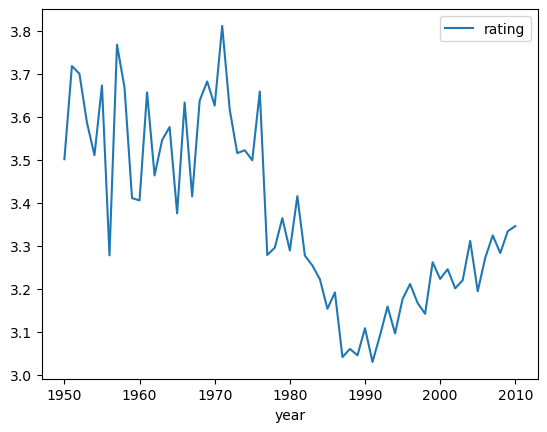

In [846]:
filtered_data4.groupby('year', as_index=False)['rating'].mean().plot(x = 'year', y = 'rating');
#динамика средней оценки фильмов в каждом году

In [848]:
#Ниже проверки и сравнения

In [850]:
#сравнение скорости обработки production_year -> быстрее
data3_1 = data3
start_time = time.time() #начало таймера
data3_1 = production_year(data3_1)
end_time = time.time() #конец таймера
execution_time = end_time - start_time #подсчет времени
print("Время выполнения: ", execution_time)

data3_1 = data3_1[(data3_1['year'] != "No data")] #удаление строк без данных по году выпуска
data3_1['year'] = data3_1['year'].astype(int)

Время выполнения:  0.09674930572509766


In [823]:
#сравнение скорости обработки assign_year
data3_2 = data3
start_time = time.time() #начало таймера
data3_2['year'] = data3_2.apply(assign_year, axis=1)
end_time = time.time() #конец таймера
execution_time = end_time - start_time #подсчет времени
print("Время выполнения: ", execution_time)

data3_2 = data3_2[(data3_2['year'] != "No data")] #удаление строк без данных по году выпуска
data3_2['year'] = data3_2['year'].astype(int)

Время выполнения:  0.6548290252685547


In [829]:
#проверка поиска года для промежутка
data3_1.loc[data3['movieId'] == 171749]

,userId,movieId,rating,title,year
16913,105,171749,5.0,Death Note: Desu nôto (2006–2007),2006


In [831]:
data3_1.groupby('year', as_index=False)['rating'].mean().sort_values(by='rating', ascending=False) 
#средняя оценка, которую ставили фильмам за каждый год

,year,rating
5,1917,4.500000
17,1930,4.205882
8,1921,4.100000
21,1934,4.088235
31,1944,4.043478
...,...,...
83,1996,3.335329
19,1932,3.333333
1,1903,2.500000
6,1919,2.000000


In [833]:
data3_1[(data3_1['year'] >= 1950)&(data3_1['year'] <= 2010)].groupby('year', as_index=False)['rating'].mean().sort_values(by='rating', ascending=False) 
#средняя оценка, которую ставили фильмам за каждый год из интересующей выборки

,year,rating
7,1957,4.039535
4,1954,4.009191
12,1962,3.969466
2,1952,3.953125
14,1964,3.940160
...,...,...
50,2000,3.398899
55,2005,3.359888
42,1992,3.354943
47,1997,3.347241


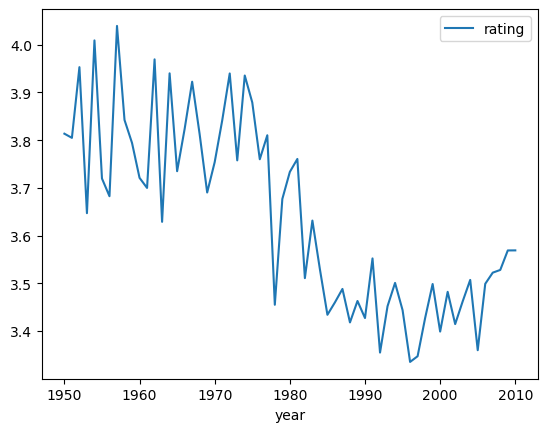

In [852]:
data3_1[(data3_1['year'] >= 1950)&(data3_1['year'] <= 2010)].groupby('year', as_index=False)['rating'].mean().plot(x = 'year', y = 'rating');
#динамика средней оценки, выставляемой пользователем в каждом году